# Two-layer neural networks in the teacher-student setting

In [8]:
# AJOUTER EARLY STOPPING : Dans le papier original regarder comment ils définissent la fin d'un apprentissage => possibilité de baisser la valeur avec un meilleur apprentissage ? 

100%|██████████| 20/20 [04:24<00:00, 13.23s/it]


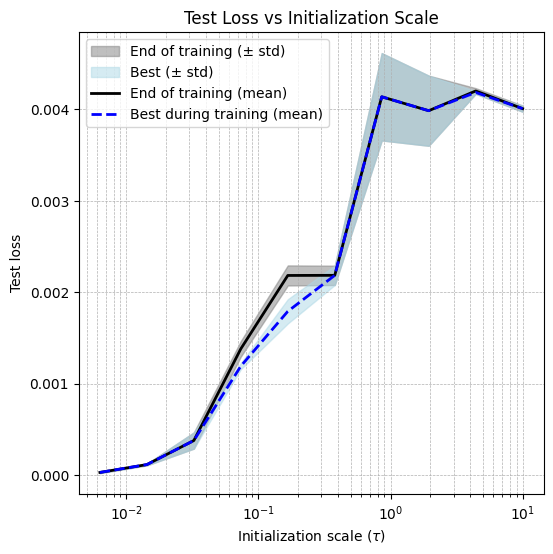

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters
d = 100  # Input dimension
n_train, n_test = 1000, 1000  # Training and test dataset sizes
m0 = 3  # Number of neurons in the teacher network
m = 50  # Number of neurons in the student network
niter = 10000  # Number of iterations
scales = np.logspace(-2.2, 1, num=10)  # Initialization scales
ntrials = 2  # Number of trials
scaling = 1.0  # Scaling factor

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Teacher Network
def generate_teacher(d, m0):
    w1 = torch.randn(m0, d)
    w1 = w1 / w1.norm(dim=1, keepdim=True)  # Normalize rows
    w2 = torch.sign(torch.randn(m0))
    return w1, w2

def teacher_output(X, w1, w2):
    return torch.sum(w2[:, None] * torch.relu(w1 @ X.T), dim=0)

# Student Network
class StudentNetwork(nn.Module):
    def __init__(self, m, d, scale):
        super(StudentNetwork, self).__init__()
        self.hidden_weights = nn.Parameter(scale * torch.randn(m, d))
        self.output_weights = nn.Parameter(scale * torch.randn(m))
    
    def forward(self, X):
        hidden_output = torch.relu(self.hidden_weights @ X.T)  # (m, n)
        return torch.sum(self.output_weights[:, None] * hidden_output, dim=0)  # (n,)

# Training and Evaluation
def train_student(X_train, Y_train, X_test, Y_test, W_init_scale, stepsize, niter, scaling):
    # Initialize the student network
    student = StudentNetwork(m, d, W_init_scale)
    optimizer = optim.SGD(student.parameters(), lr=stepsize / scaling)

    train_losses = []
    test_losses = []

    for _ in range(niter):
        # Forward pass
        Y_pred_train = scaling * student(X_train)
        train_loss = 0.5 * torch.mean((Y_pred_train - Y_train) ** 2)
        train_losses.append(train_loss.item())

        # Backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Test loss
        with torch.no_grad():
            Y_pred_test = scaling * student(X_test)
            test_loss = 0.5 * torch.mean((Y_pred_test - Y_test) ** 2)
            test_losses.append(test_loss.item())
    
    return train_losses, test_losses

# Main Experiment Loop
all_train_losses = np.zeros((niter, len(scales), ntrials))
all_test_losses = np.zeros((niter, len(scales), ntrials))

pbar = tqdm(total=len(scales) * ntrials)

for trial in range(ntrials):
    # Generate teacher network and datasets
    w1_teacher, w2_teacher = generate_teacher(d, m0)

    X_train = torch.randn(n_train, d)
    X_train = X_train / X_train.norm(dim=1, keepdim=True)  # Normalize to unit sphere
    Y_train = teacher_output(X_train, w1_teacher, w2_teacher)

    X_test = torch.randn(n_test, d)
    X_test = X_test / X_test.norm(dim=1, keepdim=True)
    Y_test = teacher_output(X_test, w1_teacher, w2_teacher)

    for i, scale in enumerate(scales):
        stepsize = min(10, 0.1 / scale**2)

        train_losses, test_losses = train_student(
            X_train, Y_train, X_test, Y_test, scale, stepsize, niter, scaling
        )

        all_train_losses[:, i, trial] = train_losses
        all_test_losses[:, i, trial] = test_losses

        pbar.update(1)

pbar.close()

# Compute mean and std of test loss
mean_test_loss_end = all_test_losses[-1, :, :].mean(axis=1)
std_test_loss_end = all_test_losses[-1, :, :].std(axis=1)
mean_test_loss_best = all_test_losses.min(axis=0).mean(axis=1)
std_test_loss_best = all_test_losses.min(axis=0).std(axis=1)

# Plot Results
plt.figure(figsize=(6, 6))
plt.fill_between(scales, mean_test_loss_end + std_test_loss_end, mean_test_loss_end - std_test_loss_end, alpha=0.5, color='gray', label='End of training (± std)')
plt.fill_between(scales, mean_test_loss_best + std_test_loss_best, mean_test_loss_best - std_test_loss_best, alpha=0.5, color='lightblue', label='Best (± std)')
plt.semilogx(scales, mean_test_loss_end, 'k-', linewidth=2, label='End of training (mean)')
plt.semilogx(scales, mean_test_loss_best, 'b--', linewidth=2, label='Best during training (mean)')
plt.xlabel(r"Initialization scale ($\tau$)")
plt.ylabel("Test loss")
plt.legend()
plt.title("Test Loss vs Initialization Scale")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm



# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Teacher Network
def generate_teacher(d, m0):
    w1 = torch.randn(m0, d)
    w1 = w1 / w1.norm(dim=1, keepdim=True)  # Normalize rows
    w2 = torch.sign(torch.randn(m0))
    return w1, w2

def teacher_output(X, w1, w2):
    return torch.sum(w2[:, None] * torch.relu(w1 @ X.T), dim=0)

# Student Network
class StudentNetwork(nn.Module):
    def __init__(self, m, d, scale):
        super(StudentNetwork, self).__init__()
        
        self.hidden_weights = nn.Parameter(scale * torch.randn(m, d))
        self.output_weights = nn.Parameter(scale * torch.randn(m))
    
    def forward(self, X):
        hidden_output = torch.relu(self.hidden_weights @ X.T)  # (m, n)
        return torch.sum(self.output_weights[:, None] * hidden_output, dim=0)  # (n,)

# Training and Evaluation
def train_student(X_train, Y_train, X_test, Y_test, W_init_scale, stepsize, niter, scaling,m):
    # Initialize the student network
    student = StudentNetwork(m, d, W_init_scale)
    optimizer = optim.SGD(student.parameters(), lr=stepsize / scaling)

    train_losses = []
    test_losses = []

    for _ in range(niter):
        # Forward pass
        Y_pred_train = scaling * student(X_train)
        train_loss = 0.5 * torch.mean((Y_pred_train - Y_train) ** 2)
        train_losses.append(train_loss.item())

        # Backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Test loss
        with torch.no_grad():
            Y_pred_test = scaling * student(X_test)
            test_loss = 0.5 * torch.mean((Y_pred_test - Y_test) ** 2) / (scaling**2)#CORRECTED!!!!!!!!!!!!!
            test_losses.append(test_loss.item())
    
    return train_losses, test_losses


In [36]:
# Parameters
d = 100  # Input dimension
n_train, n_test = 1000, 1000  # Training and test dataset sizes
m0 = 3  # Number of neurons in the teacher network
m = 50  # Number of neurons in the student network
niter = 10000  # Number of iterations
scales = np.logspace(-2.2, 3, num=30)  # Initialization scales
ntrials = 5  # Number of trials
scaling = 1.0  # Scaling factor

# Main Experiment Loop
all_train_losses = np.zeros((niter, len(scales), ntrials))
all_test_losses = np.zeros((niter, len(scales), ntrials))

pbar = tqdm(total=len(scales) * ntrials)
loss_list_max_scales = []
for trial in range(ntrials):
    # Generate teacher network and datasets
    w1_teacher, w2_teacher = generate_teacher(d, m0)

    X_train = torch.randn(n_train, d)
    X_train = X_train / X_train.norm(dim=1, keepdim=True)  # Normalize to unit sphere
    Y_train = teacher_output(X_train, w1_teacher, w2_teacher)

    X_test = torch.randn(n_test, d)
    X_test = X_test / X_test.norm(dim=1, keepdim=True)
    Y_test = teacher_output(X_test, w1_teacher, w2_teacher)

    for i, scale in enumerate(scales):
        
        stepsize = min(10, 0.1 / scale**2)

        train_losses, test_losses = train_student(
            X_train, Y_train, X_test, Y_test, scale, stepsize, niter, scaling, m
        )
        if scale == max(scales):
            loss_list_max_scales = test_losses

        all_train_losses[:, i, trial] = train_losses
        all_test_losses[:, i, trial] = test_losses

        pbar.update(1)

pbar.close()

# Compute mean and std of test loss
mean_test_loss_end = all_test_losses[-1, :, :].mean(axis=1)
std_test_loss_end = all_test_losses[-1, :, :].std(axis=1)
mean_test_loss_best = all_test_losses.min(axis=0).mean(axis=1)
std_test_loss_best = all_test_losses.min(axis=0).std(axis=1)

# Plot Results
plt.figure(figsize=(6, 6))
plt.fill_between(scales, mean_test_loss_end + std_test_loss_end, mean_test_loss_end - std_test_loss_end, alpha=0.5, color='gray', label='End of training (± std)')
plt.fill_between(scales, mean_test_loss_best + std_test_loss_best, mean_test_loss_best - std_test_loss_best, alpha=0.5, color='lightblue', label='Best (± std)')
plt.semilogx(scales, mean_test_loss_end, 'k-', linewidth=2, label='End of training (mean)')
plt.semilogx(scales, mean_test_loss_best, 'b--', linewidth=2, label='Best during training (mean)')
plt.xlabel(r"Initialization scale ($\tau$)")
plt.ylabel("Test loss")
plt.legend()
plt.title("Test Loss vs Initialization Scale")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



# Tracer la courbe avec une échelle logarithmique pour l'axe des y
plt.figure(figsize=(6, 4))
plt.plot(range(len(loss_list_max_scales[-niter//10:])), loss_list_max_scales[-niter//10:], label="Loss")
plt.yscale('log')  # Échelle logarithmique sur l'axe des y
plt.xlabel("Iterations")
plt.ylabel("Loss (log scale)")
plt.title("Loss vs Iterations (Log Scale)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()





  0%|          | 0/150 [00:18<?, ?it/s]


KeyboardInterrupt: 

  8%|▊         | 2/24 [00:31<05:46, 15.74s/it]


1


  8%|▊         | 1/12 [00:08<01:38,  8.97s/it]

2


 17%|█▋        | 2/12 [00:18<01:31,  9.15s/it]

3


 25%|██▌       | 3/12 [00:27<01:23,  9.31s/it]

4


 33%|███▎      | 4/12 [00:39<01:20, 10.10s/it]

6


 42%|████▏     | 5/12 [00:50<01:13, 10.47s/it]

8


 50%|█████     | 6/12 [01:01<01:04, 10.74s/it]

1


 58%|█████▊    | 7/12 [01:10<00:51, 10.21s/it]

2


 67%|██████▋   | 8/12 [01:19<00:39,  9.88s/it]

3


 75%|███████▌  | 9/12 [01:28<00:28,  9.60s/it]

4


 83%|████████▎ | 10/12 [01:39<00:19,  9.97s/it]

6


 92%|█████████▏| 11/12 [01:50<00:10, 10.24s/it]

8


100%|██████████| 12/12 [02:01<00:00, 10.11s/it]


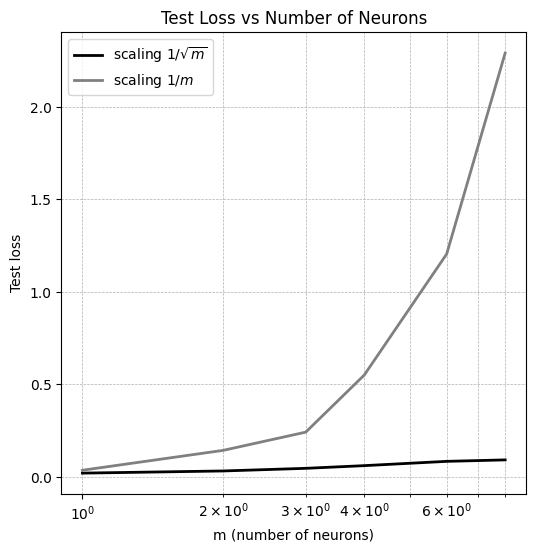

In [41]:

# Parameters
d = 100  # Dimension of the supervised learning problem
n_train, n_test = 1000, 1000  # Number of data points
m0 = 20  # Number of neurons in the ground truth
niter = 10000#WAS 25000 in the original experiment  # Number of iterations
ms = [1, 2, 3, 4, 6, 8]#, 12, 16, 24, 32, 64, 128, 256, 512]  # Student network sizes
ntrials = 1  # Number of trials


# Main Experiment
m_ltrains = np.zeros((niter, len(ms), ntrials))
m_ltests = np.zeros((niter, len(ms), ntrials))
m_ltrains2 = np.zeros((niter, len(ms), ntrials))
m_ltests2 = np.zeros((niter, len(ms), ntrials))

pbar = tqdm(total=len(ms) * ntrials * 2)

for k in range(ntrials):
    # Generate teacher network and datasets
    w1_teacher, w2_teacher = generate_teacher(d, m0)

    X_train = torch.randn(n_train, d)
    X_train = X_train / X_train.norm(dim=1, keepdim=True)  # Normalize to unit sphere
    Y_train = teacher_output(X_train, w1_teacher, w2_teacher)

    X_test = torch.randn(n_test, d)
    X_test = X_test / X_test.norm(dim=1, keepdim=True)
    Y_test = teacher_output(X_test, w1_teacher, w2_teacher)

    # Compute with alpha = 1/sqrt(m)
    for i, m in enumerate(ms):
        scaling = 1 / np.sqrt(m)
        stepsize = 1 / m
        W_init_scale = scaling
        train_losses, test_losses = train_student(X_train, Y_train, X_test, Y_test, W_init_scale, stepsize, niter, scaling, m)
        m_ltrains[:, i, k] = train_losses
        m_ltests[:, i, k] = test_losses
        pbar.update(1)

    # Compute with alpha = 1/m
    for i, m in enumerate(ms):
        scaling = 1 / m
        stepsize = 0.05 / m
        W_init_scale = scaling
        train_losses, test_losses = train_student(X_train, Y_train, X_test, Y_test, W_init_scale, stepsize, niter, scaling, m)
        m_ltrains2[:, i, k] = train_losses
        m_ltests2[:, i, k] = test_losses
        pbar.update(1)

pbar.close()

# Plot Results
meana = m_ltests[-1, :, :].mean(axis=1)
meana2 = m_ltests2[-1, :, :].mean(axis=1)

plt.figure(figsize=(6, 6))
plt.semilogx(ms, meana, 'k', linewidth=2, label=r"scaling $1/\sqrt{m}$")
plt.semilogx(ms, meana2, 'gray', linewidth=2, label=r"scaling $1/m$")
plt.xlabel("m (number of neurons)")
plt.ylabel("Test loss")
plt.legend()
plt.title("Test Loss vs Number of Neurons")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


100%|██████████| 16/16 [00:31<00:00,  1.94s/it]


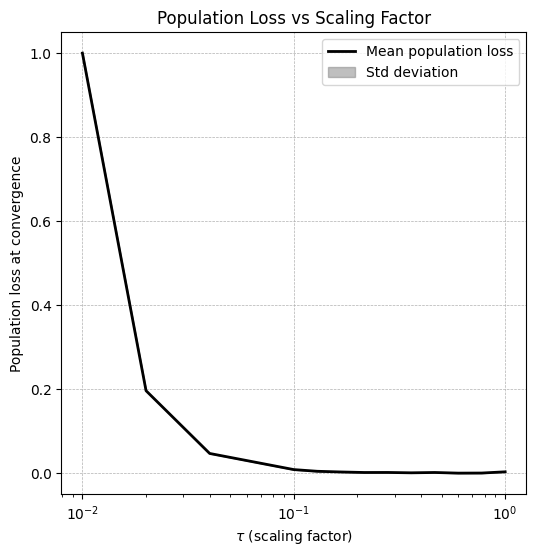

In [45]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters
d = 100  # Dimension of the supervised learning problem
m0 = 3  # Number of neurons in the teacher network
m = 50  # Number of neurons in the student network
niter = 2000  # Number of iterations
batchsize = 200
ntrials = 1  # Number of trials

# Scales (tau values)
scales = np.concatenate(([0.01, 0.02, 0.04], np.logspace(-1.0, 0.0, num=10), [2, 4, 8]))
nscales = len(scales)


# Main experiment using `train_student`
Fs = np.zeros((ntrials, nscales))  # Store population loss

pbar = tqdm(total=ntrials * nscales)

# Seed for reproducibility
torch.manual_seed(1)
np.random.seed(1)

for i in range(ntrials):
    # Generate teacher network
    theta0 = torch.randn(m0, d)
    theta0 = theta0 / theta0.norm(dim=1, keepdim=True)  # Normalize rows
    w0 = torch.sign(torch.randn(m0))

    # Create training data (fixed batch for population loss)
    X_train = torch.randn(batchsize, d)
    X_train = X_train / X_train.norm(dim=1, keepdim=True)
    Y_train = torch.sum(w0[:, None] * torch.relu(theta0 @ X_train.T), dim=0)

    X_test = torch.randn(batchsize, d)
    X_test = X_test / X_test.norm(dim=1, keepdim=True)
    Y_test = torch.sum(w0[:, None] * torch.relu(theta0 @ X_test.T), dim=0)

    for j, scale in enumerate(scales):
        # Determine step size based on scale
        stepsize = min(0.25 / scale**2, 25)

        # Train student network
        _, val_losses = train_student(X_train, Y_train, X_test, Y_test, scale, stepsize, niter, scaling=scale, m=m)

        # Compute population loss as the sum of the last 2000 losses
        Fs[i, j] = np.sum(val_losses[-2000:])
        pbar.update(1)

pbar.close()

# Plot Results
mean_Fs = Fs.mean(axis=0)
std_Fs = Fs.std(axis=0)

ss = 1 / max(mean_Fs)  # Normalize for visualization
plt.figure(figsize=(6, 6))
plt.semilogx(scales, ss * mean_Fs, 'k', linewidth=2, label="Mean population loss")
plt.fill_between(scales, ss * (mean_Fs + std_Fs), ss * (mean_Fs - std_Fs), color='gray', alpha=0.5, label="Std deviation")
plt.xlabel(r"$\tau$ (scaling factor)")
plt.ylabel("Population loss at convergence")
plt.title("Population Loss vs Scaling Factor")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.show()
